# IA-project

# Objectif
Développer un projet pour classer automatiquement différents genres musicaux à partir des fichiers audio en se basant sur leurs caractéristiques de fréquence et de domaine temporel en utilisant l’apprentissage profond et en expérimentant plusieurs approches puis comparer les résultats de chaque modèle. 



Cette partie présente les approches de ML classiques utilisées

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew #calcul d'asymétrie
from scipy.stats import kurtosis #pour un descripteur de features

In [3]:
!pip install lightgbm
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# fixation des nombres générés aléatoirement
np.random.seed(42)


L'ensemble de données se compose de 1000 pistes audio toutes les 30 secondes. Il contient 10 genres, chacun représenté par 100 pistes. Les pistes sont toutes des fichiers audio Mono 16 bits 22050 Hz au format .wav.

In [5]:
gtzan_dir = './data/genres/'

In [6]:
# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [7]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment : un petit ensemble de caractéristiques (généralement environ 10-20) qui décrivent 
    # de manière concise la forme globale d'une enveloppe spectrale (signaux).
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel() 
        

    def get_moments(descriptors):  # descriptors == features
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)  #standard deviation
            result['{}_kurtosis'.format(k)] = kurtosis(v) #kurtosis identifie si les queues d'une distribution donnée 
                                                            #contiennent des valeurs extrêmes.
            result['{}_skew'.format(k)] = skew(v)  #calcule l'asymétrie.(skewness)

        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [8]:
def read_process_songs(src_dir, debug = True):    
 
        arr_features = []

        # Read files from the folders
        for x,_ in genres.items():
            folder = src_dir + x

            for root, subdirs, files in os.walk(folder):
                for file in files:
                    # Read the audio file
                    file_name = folder + "/" + file
                    signal, sr = librosa.load(file_name)

                    # Debug process
                    if debug:
                        print("Read file: {}".format(file_name))

                    # Append the result to the data structure
                    features = get_features(signal, sr)
                    features['genre'] = genres[x]
                    arr_features.append(features)
        return arr_features

In [9]:
%%time

features = read_process_songs(gtzan_dir, debug=False)

Wall time: 35min 14s


In [10]:
df_features = pd.DataFrame(features)

In [11]:
df_features.shape

(1000, 134)

In [12]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,5514.393296,1789.366583,3176.995746,550.485825,1.277930,0.851571,9905.273438,4005.175781,6235.702536,1316.782580,...,-0.381802,-0.087361,20.820358,-32.647717,-4.103275,8.186303,0.171622,-0.170111,95.703125,0
1,5626.545444,1763.465470,2850.163030,450.508356,7.136744,1.872261,10314.404297,4155.908203,5926.993343,852.511470,...,-0.122149,0.049449,19.133057,-32.525146,-10.894270,7.584343,0.193536,0.236081,151.999081,0
2,4137.382271,1196.751465,2147.049597,394.428946,3.603367,1.476032,7751.953125,2842.382812,4376.752601,842.133273,...,-0.228953,-0.074895,11.926430,-40.928543,-14.248710,7.786307,0.161245,-0.130394,112.347147,0
3,4141.859853,1554.571724,2700.584556,411.301524,-0.256259,0.124371,7708.886719,3531.445312,5178.110839,679.032203,...,0.157388,-0.127252,16.922087,-34.641380,-13.005329,6.983782,0.370823,0.127291,99.384014,0
4,6472.152579,2069.514147,3357.385889,548.509155,1.316912,0.691435,10056.005859,4198.974609,6810.304320,964.532861,...,-0.134480,0.061888,23.652538,-27.224190,-3.429460,7.443414,0.033727,0.119981,135.999178,0


In [13]:
df_features.to_csv('../data/gtzan_features.csv', index=False)

In [14]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization


Standardisation en utilisant StandardScaler()

In [15]:
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [16]:

pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8737


In [17]:

lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [18]:

tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.269s...
[t-SNE] Computed neighbors for 1000 samples in 1.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.258477
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.883835
[t-SNE] KL divergence after 1000 iterations: 1.028086


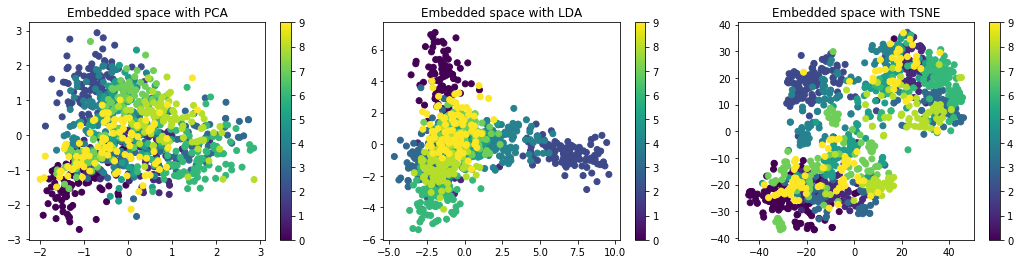

In [19]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

## Classical Machine Learning

In [20]:
# Pour utilisation de la matrice de confusion  (from scikit-learn )

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression

In [22]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [23]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7493
best score on test set (accuracy) = 0.7560


### ElasticNet

In [24]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [25]:
preds = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.6907
best score on test set (accuracy) = 0.6600


### Decision Tree

In [26]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
    

In [27]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5160
best score on test set (accuracy) = 0.5040


### Random Forest

In [28]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
    

In [29]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7107
best score on test set (accuracy) = 0.7080


### SVM

In [30]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [31]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7627
best score on test set (accuracy) = 0.8080


## Results (SVM)

In [32]:
cm = confusion_matrix(y_test, preds) 
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

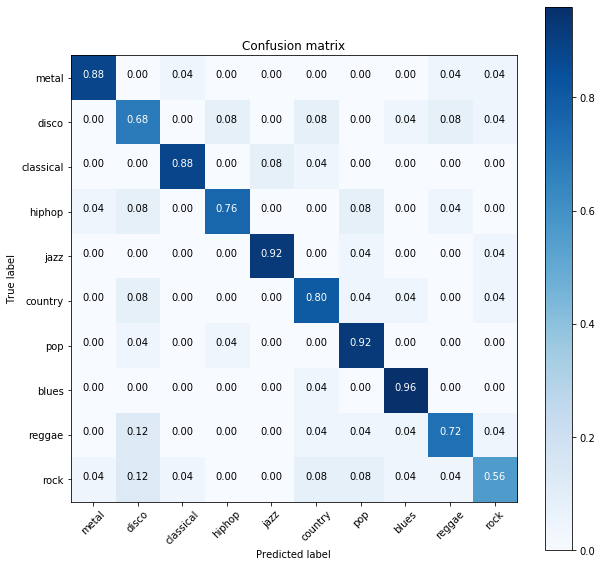

In [33]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)